In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import urllib.request
import seaborn as sns
# Clase para realizar componentes principales
from sklearn.decomposition import PCA
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
url_csv = 'https://raw.githubusercontent.com/P11-P11/Data-Science/Regression/df_arabica_clean.csv'
dff = pd.read_csv(url_csv)

#Proponemos como ejercicio determinar Total cup points

# Seleccionamos las features que a priori pensamos pueden ser importantes

In [3]:
df = dff[['Country of Origin', 'Farm Name','Processing Method','Altitude','Variety',
       'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Total Cup Points','Moisture Percentage']].copy()



# Pre procesamos altitud para que sea numerica, los valores que estan como rango le asignamos el promedio

In [4]:

def procesar_alturas(df):
    alturas = df['Altitude'].values
    res = []
    for altura in alturas:
        try:
            if isinstance(altura, str):  # Verifica si es una cadena (string)
                if 'A' in altura:
                    aux = altura.split('A')
                elif '~' in altura:
                    aux = altura.split('~')
                else:
                    aux = altura.split('-')
                for i in range(len(aux)):
                    aux[i] = int(aux[i])
                prom = np.array(aux).mean()
                res.append(prom)
            elif np.isnan(altura):
                res.append(np.nan)
            else:  # Si no es una cadena, asumimos que es un número y lo agregamos directamente
                res.append(altura)
        except TypeError:
            print(f"Altura problemática: {altura}")

    return res


In [5]:
alturas = procesar_alturas(df)
df['Altitude'] = alturas
df = df.dropna() # habia uno

<ipython-input-6-014f729b46bc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


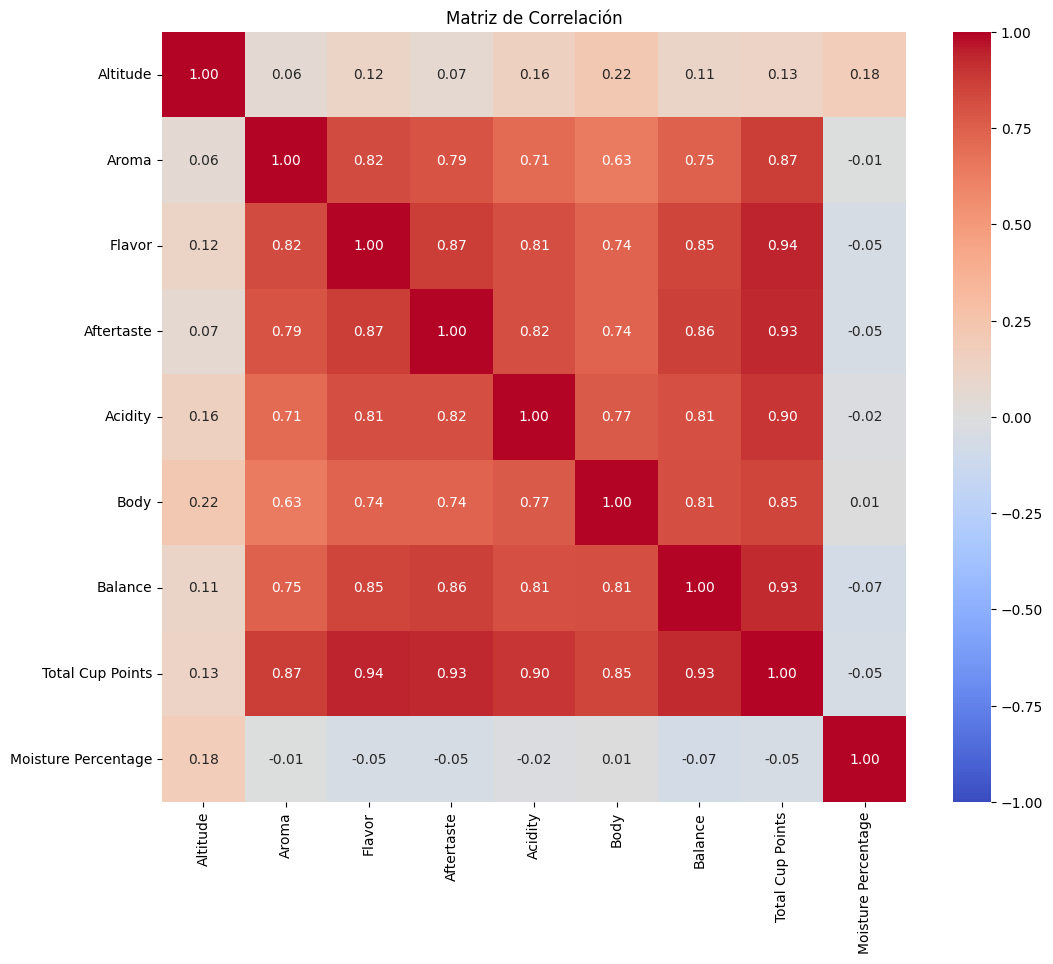

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()


# Debemos seleccionar features que esten correlacionadas con nuestro target pero poco correlacionadas entre si

Aroma Flavor Aftertaste Acidity Body y Balance paracen ser muy buenas candidatas, el problema es que entre ellas la corrleacion es relativamente alta.

Veamos si podemos resolver esto con PCA

Pondremos estas features en una matriz y vamos a ver las componentes principales de modo que nos quedemos con direcciones Independientes

In [7]:
features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
X = df[features].to_numpy().copy()


In [8]:
std_scale = StandardScaler()
# Ajustamos el estandarizador
std_scale.fit(X)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_scaled = std_scale.transform(X)
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

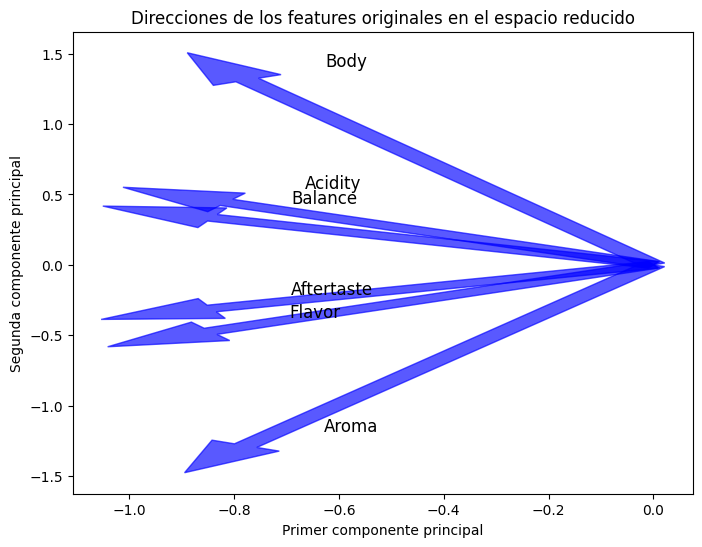

In [9]:
# Matriz de features en el espacio de componentes principales
# Simplemente la matriz traspuesta de las componentes principales en el espacio de features
features_pc = pca.components_.T

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Hacemos el gráfico de las flechas indicando las direcciones de los features originales
sf = 2 # Factor de escala solo a efecto de estirar las flechas para que sean visibles (solo nos importa la dirección en realidad)

# Recorremos cada feature
for i, feature in enumerate(features):
    # Creamos una flecha que vaya del origen y apunte en la dirección de los features
    ax.arrow(0, 0, sf * features_pc[i][0], sf * features_pc[i][1], width=0.05, color='b', alpha=0.65)

    # Ajustamos la posición del texto para que no salga pegado a la flecha
    x_offset, y_offset = 0.15, 0.1
    ax.text(sf * features_pc[i][0] + x_offset, sf * features_pc[i][1] + y_offset, s=feature, fontdict={'color': 'k', 'size': 12})


# Configuramos el gráfico
ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')
ax.set_title('Direcciones de los features originales en el espacio reducido')

plt.show()


# Podemos tomar Aroma y Body sin problemas porque forman direcciones independientes,podemos tomar Aftertaste/Flavor y Acidity/Balance




# Para confirmar nuestras sospechas hacemos scatter plots de las features vs target

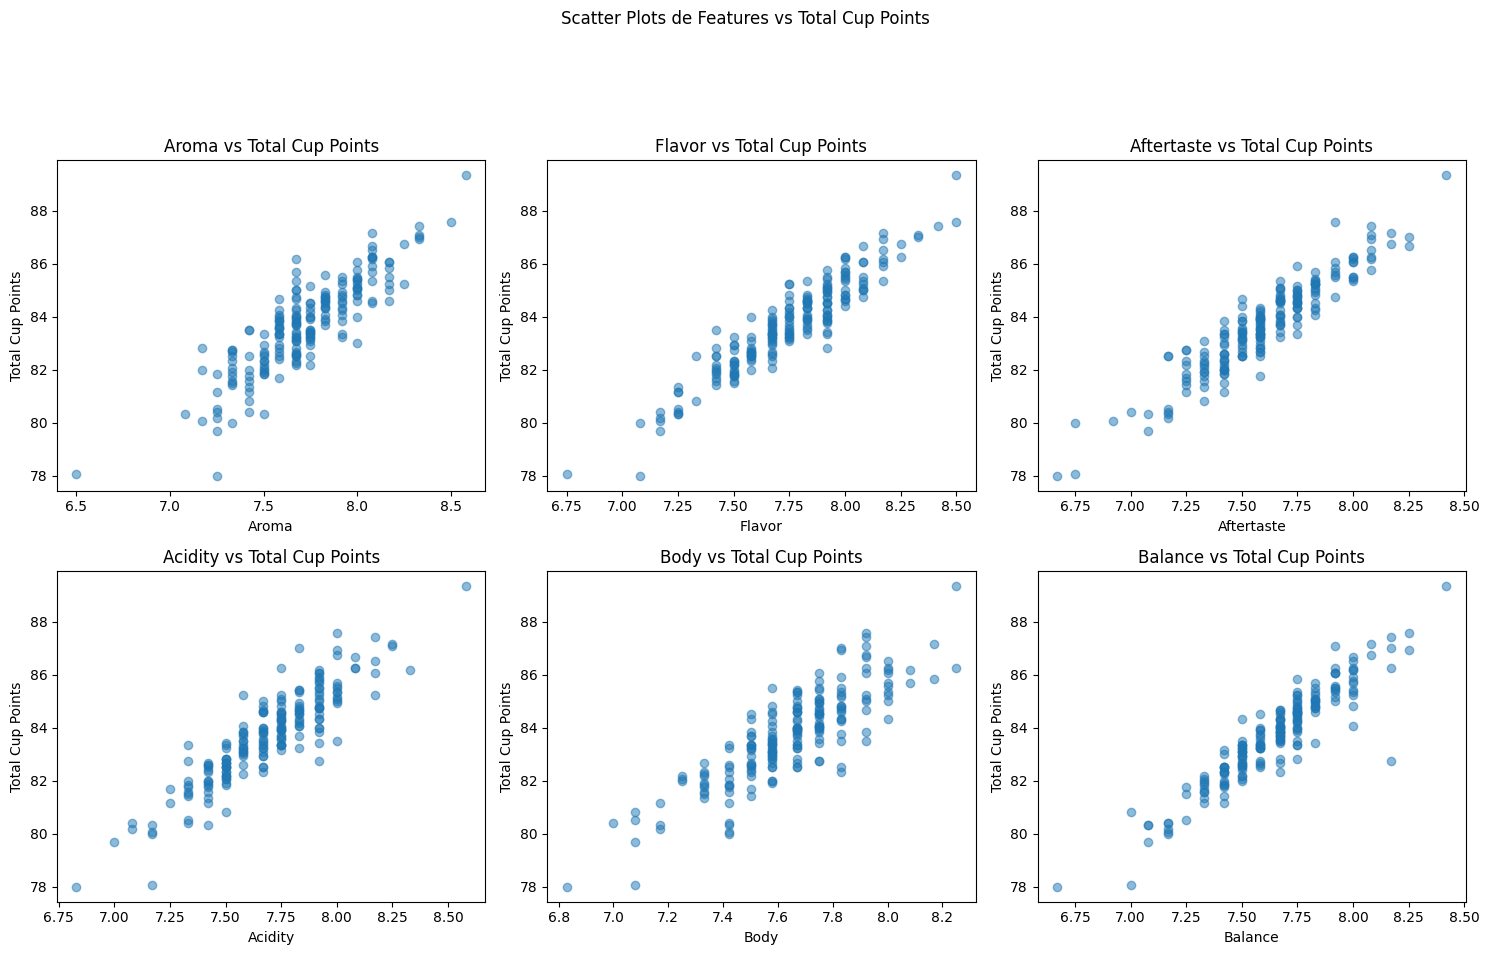

In [11]:
# Crear subgráficos
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Scatter Plots de Features vs Total Cup Points')

# Hacer scatter plots para cada feature (primeros 6 plots)
for i, feature in enumerate(features):

    row = i // 3
    col = i % 3
    axs[row, col].scatter(df[feature], df['Total Cup Points'], alpha=0.5)
    axs[row, col].set_title(f'{feature} vs Total Cup Points')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Total Cup Points')


# Ajustar diseño y mostrar gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()


# Tenemos una relacion lineal para cada feature con el target !

Ahora si armamos nuestro modelo

In [12]:
features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
X = df[features].to_numpy()
y = df['Total Cup Points'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

reg = LinearRegression()
reg.fit(X_train,y_train)

estimated = [reg.intercept_, reg.coef_]  # los parametros estimados
R2 = reg.score(X_train,y_train) # R2
print(f"R2 en el conjunto de entrenamiento {R2.round(3)}")


R2 en el conjunto de entrenamiento 0.99


In [14]:
y_pred = reg.predict(X_test)

R2_test = r2_score(y_test, y_pred)
print("R2 en el conjunto de prueba:", R2_test.round(3))

mse_test = mean_squared_error(y_test, y_pred)
print("MSE en el conjunto de prueba:", mse_test.round(3))


R2 en el conjunto de prueba: 0.996
MSE en el conjunto de prueba: 0.015


#Parece que nos fue muy bien.

#Por último chekiemos que las hipotesis de Homocedasticidad y Normalidad de los residuos se cumplan

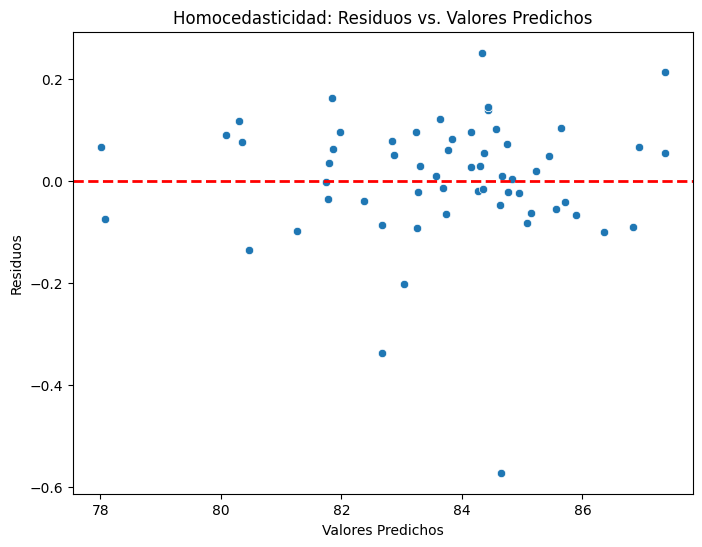

In [15]:

residuos = y_test - y_pred

# Gráfico de Residuos vs. Valores Predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Homocedasticidad: Residuos vs. Valores Predichos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.show()


# Podemos ver que la mayoria de los residuos caen en la banda [-0.2,0.2] por lo que el supuesto de Homocedasticidad parace cumplirse

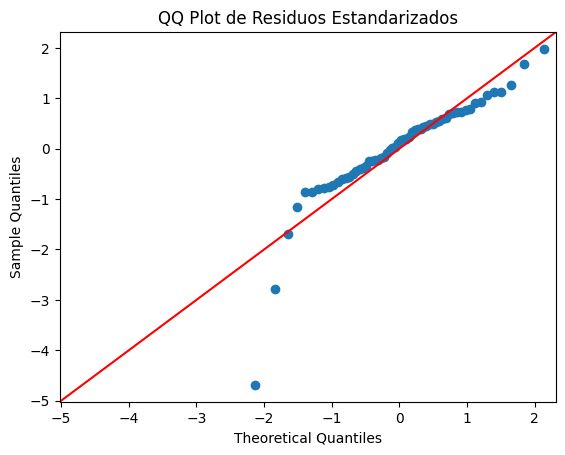

In [16]:

# Calcular residuos estandarizados
residuos_estandarizados = (y_test - y_pred) / np.sqrt(mse_test)

# QQ plot de residuos estandarizados
sm.qqplot(residuos_estandarizados, line='45', fit=True)
plt.title('QQ Plot de Residuos Estandarizados')
plt.show()


# Vemos que la normalidad de los residuos no es muy buena pero tampoco tan mala

# Por ultimo una visualizacion intuitiva de nuestros resultados, vemos que los valores reales y los predichos estan sumamente superpuestos

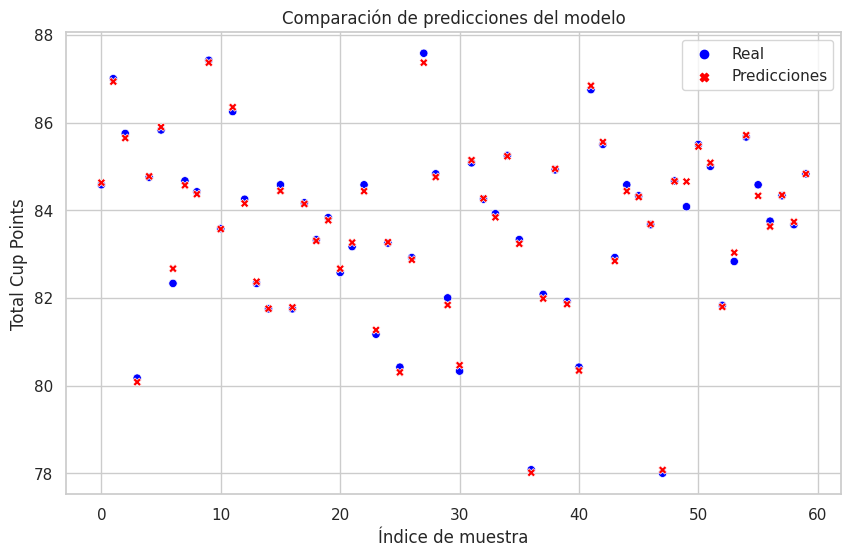

In [17]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear un DataFrame con los valores reales y las predicciones
df_comparacion = pd.DataFrame({'Real': y_test, 'Predicciones': y_pred})

# Graficar los valores reales y las predicciones
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_comparacion, palette={'Real': 'blue', 'Predicciones': 'red'})
plt.xlabel('Índice de muestra')
plt.ylabel('Total Cup Points')
plt.title('Comparación de predicciones del modelo')
plt.legend()
plt.show()